In [1]:
from SCA_classes import Segmentation_Collision_Avoidance, Debug_Timer, Config, timeit
import numba_functs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import cv2
import time
import yaml
import glob
from ultralytics import FastSAM
from collections import defaultdict
from shapely.geometry import Point, Polygon
from numba import njit, prange
from timeit import default_timer as timer
from PIL import Image
from scipy import stats

rgbImgs = sorted(glob.glob("../oakd_data/streetViewData_view1/rgb_video/*.png"))
depthImgs = sorted(glob.glob("../oakd_data/streetViewData_view1/disparity/*.png"))

In [3]:
sca = Segmentation_Collision_Avoidance("config")
for i in range(rgbImgs.__len__()):
    Debug_Timer.start("Loop")
    sca.add_image_file(rgbImgs[i], depthImgs[i])
    sca.get_steering_angle(.5, bang_bang=True)
    Debug_Timer.stop("Loop")
Debug_Timer.print_all()

Loop:
	total = 79.59946765052155, 305 samples
	avg = 0.260981861149251, min = 0.21298770001158118, max = 0.3321574470028281
fastSAM:
	total = 38.26781138544902, 311 samples
	avg = 0.12304762503359815, min = 0.09854654688388109, max = 0.7774155042134225
frame init:
	total = 26.20865567261353, 311 samples
	avg = 0.08427220473509174, min = 0.030965976882725954, max = 5.006888302974403
image resizing:
	total = 16.872637597378343, 311 samples
	avg = 0.05425285401086284, min = 0.04921076213940978, max = 0.07470256695523858
populate_objects:
	total = 7.62072655884549, 311 samples
	avg = 0.02450394391911733, min = 0.00880509102717042, max = 0.03169629815965891


In [2]:
# Debug_Timer.turn_off()
# sca = Segmentation_Collision_Avoidance("config")
# print(rgbImgs.__len__())
# for i in range(rgbImgs.__len__()):
#     sca.add_image_file(rgbImgs[i], depthImgs[i])
#     fig = sca.plot()
#     plt.savefig("figs/crosswalk_straight/" + "{:04d}".format(i) + ".jpg")
#     plt.close()
#     print(i)

In [ ]:
# frames = [Image.open(image) for image in sorted(glob.glob("figs/crosswalk_straight/*.jpg"))]
# frame_one = frames[0]
# frame_one.save("gifs/cs_rt.gif", format="GIF", append_images=frames[1:],
#             save_all=True, duration=200, loop=0)

/home/linden/anaconda3/envs/FastSAM/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


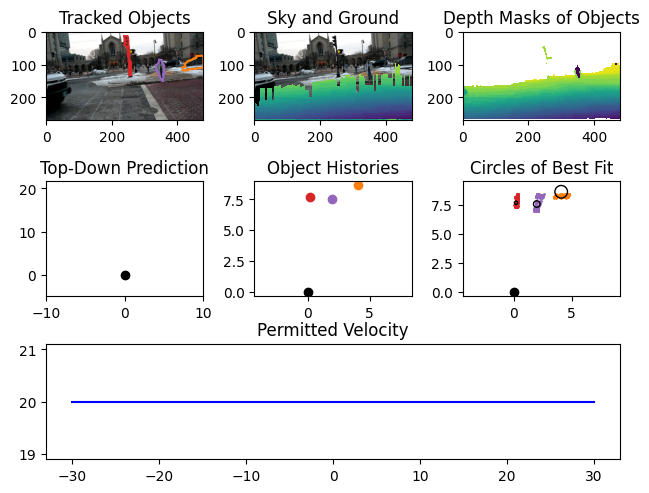

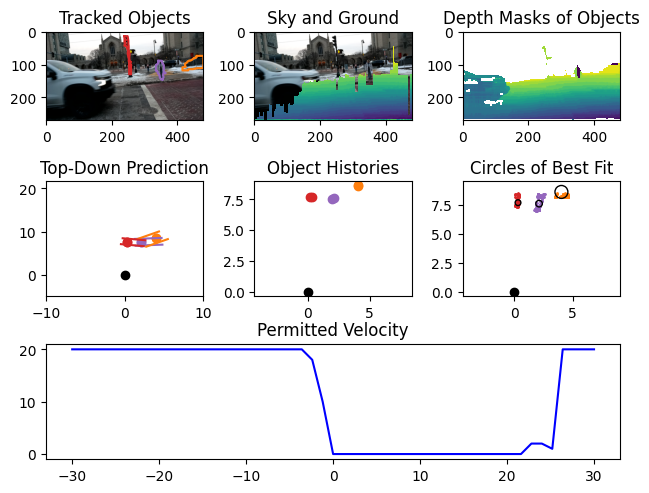

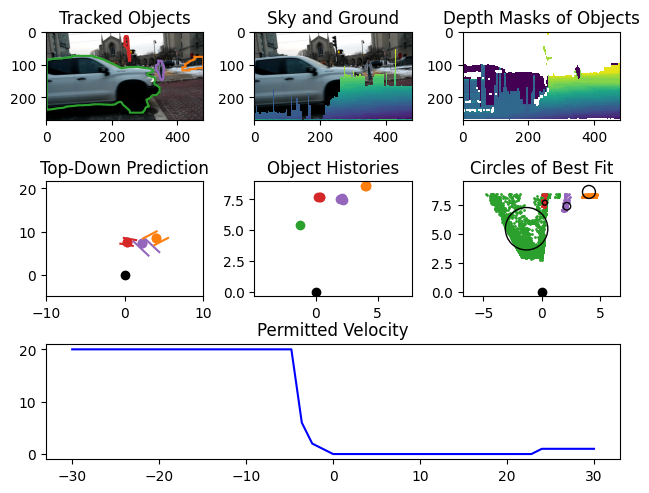

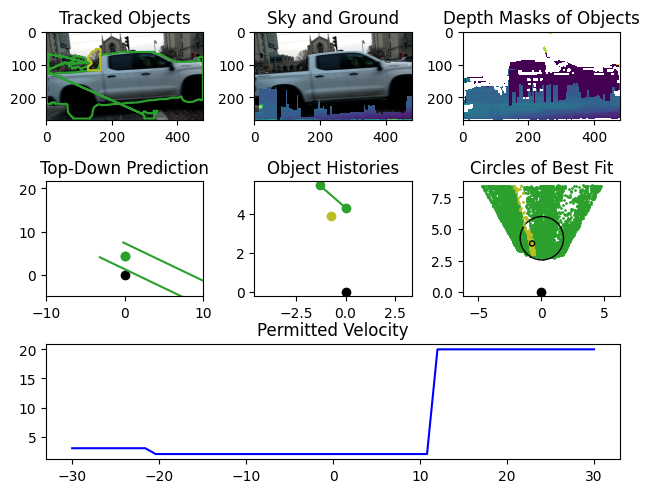

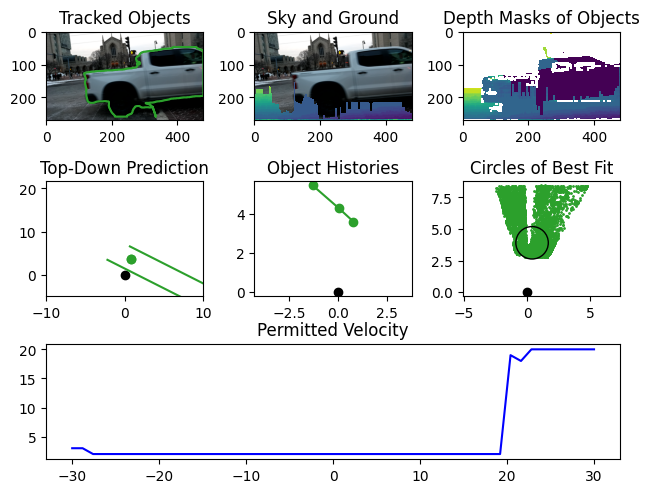

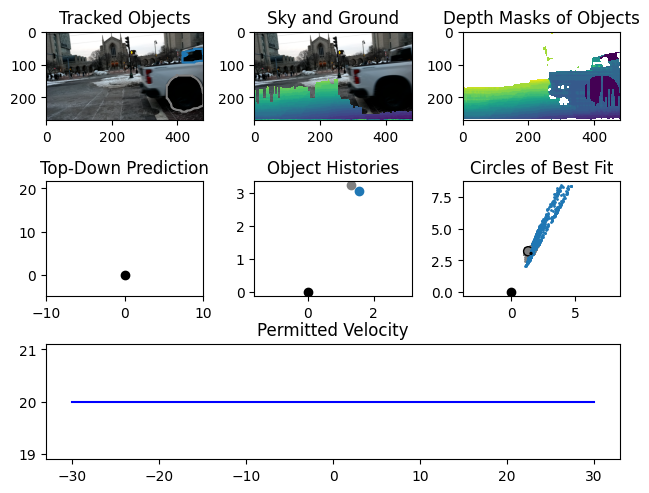

In [2]:
idx = 59 #138 for bad ground
sca = Segmentation_Collision_Avoidance("config")
for i in range(6):
    sca.add_image_file(rgbImgs[i + idx], depthImgs[i + idx])
    sca.get_steering_angle(.5, bang_bang=True)
    fig = sca.plot()

In [8]:
# SAVE!!!!

def get_ground(column, cartImg, draw=True):
    outline = np.asarray([cartImg[:,column,2], cartImg[:,column,1], np.zeros(cartImg[:,0,0].shape[0]) - 1]).T[::-1,:]
    outline_nanless = outline[np.logical_not(np.isnan(outline))[:,0],:]
    length = outline_nanless.shape[0]
    # if draw:
    start = np.where(np.min(outline_nanless[:,0]) == outline_nanless[:,0])[0][0]
    # Debug_Timer.start("put in buckets")
    lda = .25
    max_dist = 1#.4
    max_angle = .5
    curr_bucket = np.max(outline_nanless[:,0]) ** 2
    prev_bucket = np.max(outline_nanless[:,0]) ** 2
    bucket_i = -1
    buckets = np.zeros((length, 3)) # [x, y, total]
    for p_i in range(start, length):
        point = outline_nanless[p_i,0:2]
        if abs(point[0] - curr_bucket) < lda:
            outline_nanless[p_i,2] = bucket_i
            buckets[bucket_i, 0:2] += point
            buckets[bucket_i, 2] += 1
            curr_bucket = buckets[bucket_i, 0] / buckets[bucket_i, 2]
            continue
        if abs(point[0] - prev_bucket) < lda:
            outline_nanless[p_i,2] = bucket_i - 1
            buckets[bucket_i - 1, 0:2] += point
            buckets[bucket_i - 1, 2] += 1
            prev_bucket = buckets[bucket_i - 1, 0] / buckets[bucket_i - 1, 2]
            continue
        bucket_i += 1
        prev_bucket = curr_bucket
        curr_bucket = point[0]
        buckets[bucket_i, 2] += 1
        buckets[bucket_i, 0:2] += point
    buckets = buckets[:bucket_i + 1,0:2] / buckets[:bucket_i + 1,2].reshape(bucket_i + 1,1)
    # if draw:
    # Debug_Timer.stop("put in buckets")
    # Debug_Timer.start("find idx")
    dist = np.sum(np.square(buckets[:-1,:] - buckets[1:,:]), axis=1)
    angle = np.acos(abs(buckets[:-1,0] - buckets[1:,0]) ** 2 / dist)
    done = buckets.shape[0] - 1
    for i in range(buckets.shape[0] - 2):
        if draw:
            print(dist[i + 1], abs(angle[i] - angle[i + 1]))
        if dist[i + 1] > max_dist or abs(angle[i] - angle[i + 1]) > max_angle:
            done = i + 1
            break
    if done >= buckets.shape[0]:
        done = buckets.shape[0] - 1
    c = buckets[done]
    mini = np.max(outline_nanless[:,0]) - np.min(outline_nanless[:,0])
    for i in range(start, outline.shape[0]):
        dist = np.sum(np.square(c - outline[i,0:2]))
        if dist < mini:
            mini = dist
            idx = i
    if draw:
        colors = list(mcolors.TABLEAU_COLORS.values())
        for i in range(buckets.shape[0]):
            thing = outline_nanless[np.where(outline_nanless[:,2] == i)[0],:]
            plt.scatter(thing[:,0],thing[:,1],color=colors[i % len(colors)])
        plt.scatter(buckets[:,0],buckets[:,1],color='k',s=1)
        plt.scatter(outline[idx,0],outline[idx,1],color='w')
        model = np.poly1d(np.polyfit(outline_nanless[:,0], outline_nanless[:,1], 2))
        polyline = np.linspace(np.max(outline_nanless[:,0]), np.min(outline_nanless[:,0]), 50)
        plt.plot(polyline, model(polyline))
    # Debug_Timer.stop("find idx")
    return idx

# SAVE!!!!

In [9]:
sca = Segmentation_Collision_Avoidance("config")
idx = 140
sca.add_image_file(rgbImgs[idx], depthImgs[idx])

window = sca.window
frame = window.frame

nan_depthImg = np.where(frame.low_confidence, np.nan, frame.depthImg)
ori_ground = np.zeros(frame.depthImg.shape, dtype=bool)
cartImg = np.zeros(frame.cartImg.shape)
for i in range(3):
    cartImg[:,:,i] = np.where(frame.low_confidence, np.nan, frame.cartImg[:,:,i])
length = frame.depthImg[:,0].shape[0]
for i in range(cartImg.shape[1]):
    idx = get_ground(i, cartImg, False)
    ori_ground[length - idx:,i] = True
plt.imshow(frame.ground)
plt.figure()
plt.imshow(ori_ground)
plt.figure()
ground = np.where(ori_ground, 0, np.nan)
plt.imshow(frame.depthImg)
plt.figure()
plt.imshow(frame.rgbImg)
plt.figure()
plt.imshow(nan_depthImg)
plt.figure()
plt.imshow(frame.depthImg)
plt.imshow(ground)
plt.figure()
plt.imshow(frame.rgbImg)
plt.imshow(ground)

KeyboardInterrupt: 

0.15122219418519722 0.04592100886471662
0.18317206224607008 0.0334220108024087
0.10935298218868515 0.007240093662340907
0.11873508923907201 0.012495240879671243
3.3048693565809684 0.00609258058739004
506


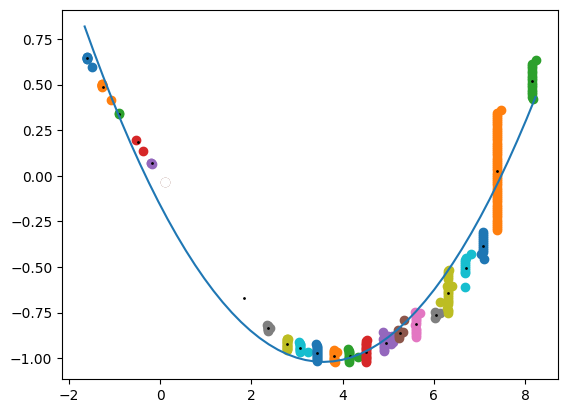

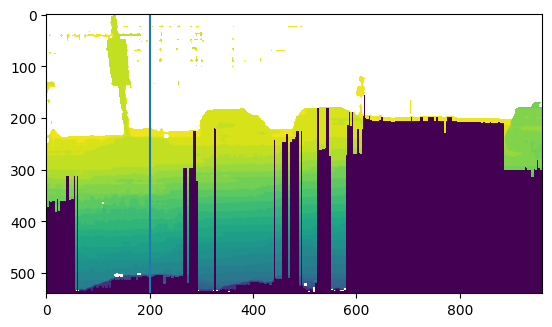

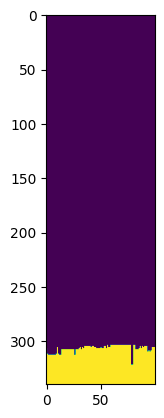

In [ ]:
column = 200
cartImg = np.empty(frame.cartImg.shape)
for i in range(3):
    cartImg[:,:,i] = np.where(frame.low_confidence, np.nan, frame.cartImg[:,:,i])
print(length - get_ground(column, cartImg))
plt.figure()
plt.imshow(nan_depthImg)
plt.imshow(ground)
plt.plot([column, column],[0,nan_depthImg.shape[0] - 1])
plt.figure()
a = column - 50
e = column + 50
# plt.imshow(nan_depthImg[200:,a:e])
plt.imshow(ori_ground[200:,a:e])
# plt.plot([50, 50],[0,nan_depthImg.shape[0] - 200 - 1])

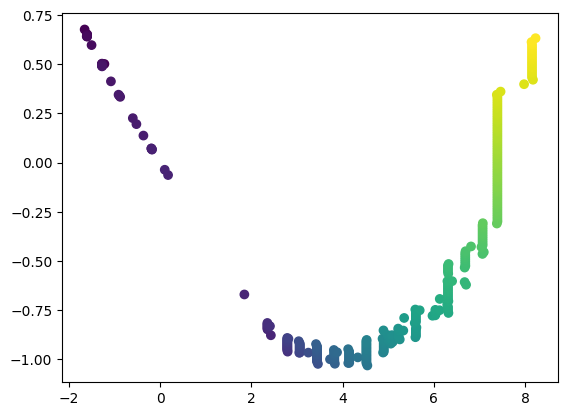

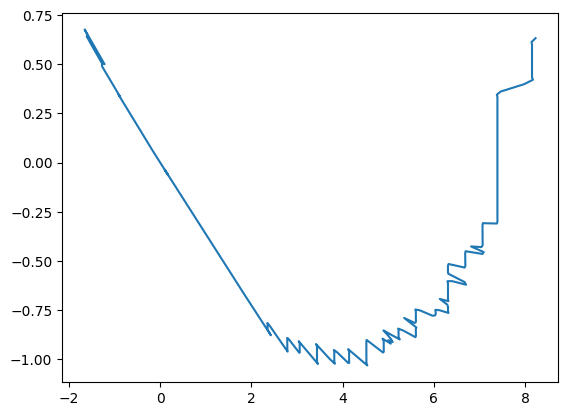

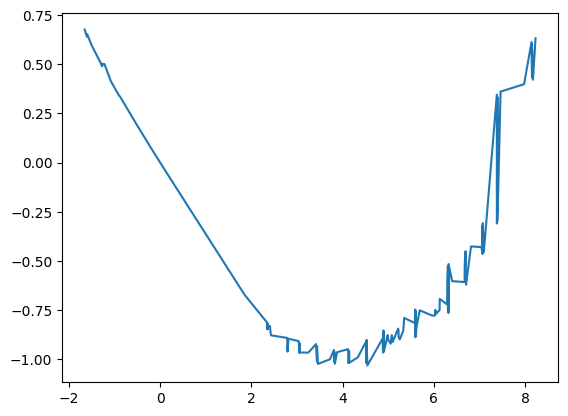

In [ ]:
outline = np.asarray([cartImg[:,column,2], cartImg[:,column,1], np.zeros(cartImg[:,0,0].shape[0]) - 1]).T[::-1,:]
outline_nanless = outline[np.logical_not(np.isnan(outline))[:,0],:]
plt.scatter(outline[:,0],outline[:,1],c=np.linspace(0,1,outline.shape[0]))
plt.figure()
plt.plot(outline_nanless[:,0],outline_nanless[:,1])
plt.figure()
sorted = outline_nanless[outline_nanless[:,0].argsort(),:]
plt.plot(sorted[:,0],sorted[:,1])

In [ ]:
# sca = Segmentation_Collision_Avoidance("config")
# # for i in range(10):
# #     sca.add_CARLA_image_file("1080p" + str(i + 40))

# for i in range(6):
#     sca.add_OAKD_image_file(str(i + 73))
#     fig = sca.plot2()
#     # plt.savefig("figs/" + str(i) + ".jpg")
#     # plt.close()

# # for i in range(6): # 2, 6
# #     sca.add_OAKD_image_file("2_" + str(i + 69))
# #     fig = sca.plot()
# #     plt.savefig("figs/" + str(i + 6) + ".jpg")
# #     plt.close()

In [ ]:
# window = sca.window
# frame = window.frame

In [ ]:
# plt.imshow(frame.rgbImg)
# plt.figure()
# plt.imshow(frame.depthImg)
# # [vertical, horizontal]